# Kernel Methods (Primal vs. Dual View)

In this lab we explore how kernel methods can be used on structured data as long as a kernel function can be defined on pairs of objects of data. Specifically, we will use the dynamic time-warping (DTW) kernel to perform learning on sequences. We then proceed to train a kernelized SVM with the DTW kernel on a sequence data set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. DTW Kernel

Given a metric $d: X \times X \rightarrow \mathbb{R}_{\geq 0}$ on the input space $X$, the family of *DTW Kernels* is given as:

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

for sequences $x, x' \in X^+ := \bigcup_{n \geq 1}{X^n}$ of lengths $|x|$ and $|x'|$. The *DTW distance metric* $d_{\text{DTW}}$ is then given by $\gamma(|x|, |x'|)$, where the helper function $\gamma$ is defined recursively via:

$$ \gamma(i, j) = \begin{cases} d(x_i, x_j') + \min\left(\gamma(i-1, j-1), \gamma(i-1, j), \gamma(i, j-1)\right) & (1 \leq i \leq |x|, \, 1 \leq j \leq |x'|), \\ 
\infty & i = 0 \vee j = 0, \\
0 & (i, j) = (0, 0). \end{cases}
$$

The intuition is that $\gamma(i, j)$ is the minimum squared distance up to time $i$ and $j$. $i = |x|$ and $j = |x'|$ are edge cases in the sense that the if a sequence has ended it cannot be matched anymore (and thus the value are infinite or the result value as both have been matched).

To compute $d_{\text{DTW}}$ the technique of <a href="https://en.wikipedia.org/wiki/Dynamic_programming" target="_blank">Dynamic Programming</a> is being used, where you store $\gamma$ in a $(|x|+1) \times (|x'|+1)$ grid.

<b>Exercise 1</b>:

Implement the function *d_DTW(x, x2, dist)*. The inputs x and x2 are the sequences to be compared and the parameter dist is a function on a pairs of points of the input space $X$ that outputs a real number (the distance between the pairs of points). Some code is given to help you dealing with the edge cases. The function is supposed to return the value of $d_{\text{DTW}}$ (The distance between x and x2) with the specified parameters, *not* the $k_{\text{DTW}}$.

In [3]:
def d_DTW(x, x2, dist):
    t1, t2 = len(x), len(x2)
    
    #Edge Cases
    
    if x == [] and x2 == []:
        return 0.0
    elif (x == []) or (x2 == []):
        return np.infty
    
    dp = np.empty((t1+1, t2+1))    
    dp[0, 0] = 0    
    
    for i in range(1, t1+1):
        dp[i, 0] = np.infty
    
    for j in range(1, t2+1):
        dp[0, j] = np.infty
        
    #Standard Procedure
    
    # WRITE YOUR CODE HERE
    for i in range(1,t1+1):
        for j in range(1,t2+1):
            cost = dist(x[i-1], x2[j-1])
            dp[i,j] = cost + np.min([dp[i-1,j-1], dp[i-1,j], dp[i,j-1]])
    
    #print(np.flip(dp, axis=0))
    return dp[t1, t2]

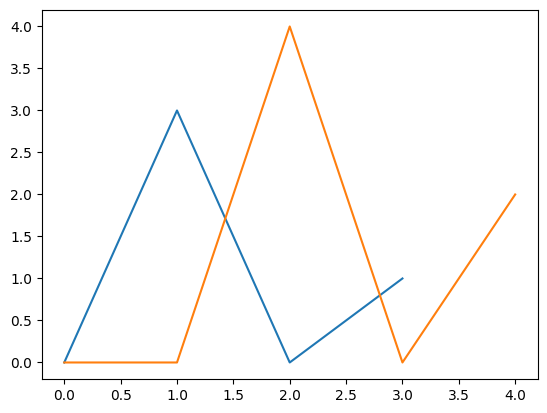

In [11]:
# Example
x = [0,3,0,1]
x2 = [0,0,4,0,2]

d_DTW(x,x2, lambda x,x2:(x-x2)**2)

plt.plot(x)
plt.plot(x2)

Check your solution:

In [4]:
try:
    assert d_DTW([1, 2, 3, 3], [1, 2, 3], lambda x, y: 1 if x != y else 0) == 0.0
    assert d_DTW([1, 2, 3, 4], [1, 2, 3], lambda x, y: 1 if x != y else 0) == 1.0
    assert d_DTW([1, 2, 3, 2], [1, 2], lambda x, y: 1 if x != y else 0) == 1.0
    assert d_DTW([], [1, 2], lambda x, y: 1 if x != y else 0) == np.infty
    assert d_DTW([], [], lambda x, y: 1 if x != y else 0) == 0.0
    print("There is no error in your function!")
except AssertionError:
    print("There is an error in your function!")

There is no error in your function!


We define three distance functions on two values $x, x' \in X$:

$d_1(x_2, x_2) = \mathbb{1}[x_1 != x_2]$, (a boolean Value should be returned)

$d_2(x_1, x_2) = (x_1 - x_2)^2$,

$d_3(x_1, x_2) = |x_1 - x_2|$,

Optional: $d_4(\Delta x_i, \Delta x'_i) = (\Delta x_i - \Delta x'_i)^2$, with
$$ \Delta x_i = \frac{1}{2}\left( x_i - x_{i-1} + \frac{x_{i+1} - x_{i-1}}{2}\right) $$
as *approximate derivates of order 2*. Note that the edge cases are $\Delta x_1 = 0$ and $\Delta x_{|x|} = x_{|x|} - x_{|x|-1}$. 

*Hint*: It's best to map the sequences $x = (x_1, \dots, x_{|x|})$ to $\Delta x = \left(\Delta x_1, \dots, \Delta x_{|x|}\right)$ and then apply $d_2$.

<b>Exercise 2</b>:

Implement the missing distance metrics.

In [5]:
def d1(x, x2):
    return x!=x2

def d2(x, x2):
    return (x-x2)**2

def d3(x, x2):
    return abs(x-x2)


The following code lifts the distance metrics to maps that map a given hyperparameter $\lambda$ return the corresponding kernel function $k_{\text{DTW}}$.

In [12]:
def calculate_delta_x(x):
    delta_x = [0] * len(x)
    delta_x[0] = 0
    delta_x[-1] = x[-1] - x[-2]
    
    for i in range(1,len(x) - 1):
        delta_x[i] = 0.5 * (x[i] - x[i-1] + (x[i+1]-x[i-1])/2)
    return delta_x

def d4(delta_x1,delta_x2):
    return d2(delta_x1,delta_x2)

In [14]:
x1 = [1,2,3,5,0]
x2 = [2,5,10,10,6]

delta_x1 = calculate_delta_x(x1)
delta_x2 = calculate_delta_x(x2)

print(delta_x1)
print(delta_x2)

d4(delta_x1[4],delta_x2[4])

[0, 1.0, 1.25, 0.25, -5]
[0, 3.5, 3.75, -1.0, -4]


1

In [15]:
k1_hyp, k2_hyp, k3_hyp = [lambda lmbd: (lambda x, x2: np.exp(-lmbd * d_DTW(x, x2, d))) for d in [d1, d2, d3]]

In [16]:
k1 = k1_hyp(2.0)
k2 = k2_hyp(2.0)
k3 = k3_hyp(2.0)

The following code computes the Gram matrix $K$ with respect to the kernel $k$ (a parameter) and the data $xs$ (another parameter), see slide 28 and 29 in Kernel Methods lecture.

In [17]:
def build_dtw_gram_matrix(xs, x2s, k):
    """
    xs: collection of sequences (vectors of possibly varying length)
    x2s: the same, needed for prediction
    k: a kernel function that maps two sequences of possibly different length to a real
    The function returns the Gram matrix with respect to k of the data xs.
    """
    t1, t2 = len(xs), len(x2s)
    K = np.empty((t1, t2))
    
    for i in range(t1):
        for j in range(i, t2):
            K[i, j] = k(xs[i], x2s[j])
            if i < t2 and j < t1:
                K[j, i] = K[i, j]
        
    return K
    

In [18]:
build_dtw_gram_matrix([[1, 2], [2, 3]], [[1, 2, 3], [4]], k1)

array([[1.35335283e-01, 4.53999298e-05],
       [4.53999298e-05, 2.47875218e-03]])

## 2. Kernel SVM

Now we implement the training algorithm for kernel SVMs. We adjust the ERM learning algorithm from the linear classification lab. First we are reusing the code for the $\mathcal{L}_2$-regularizer and the hinge loss.

In [21]:
def L2_reg(w, lbda):
    return 0.5 * lbda * (np.dot(w.T, w)), lbda*w

def hinge_loss(h, y):
    n = len(h)
    l = np.maximum(0, np.ones(n) - y*h)
    g = -y * (h > 0)
    return l, g

<b>Exercise 3</b>:

Adjust the old code (Lab 06) to actually learn the kernel linear regression. Note that there is a new parameter $k$ that encodes the kernel function. Note that lbda is not the $\lambda$ used in the definition of $k$, but the regularization coefficient (as before). Note also that the learning rate $\alpha$ has been renamed to $\eta$, because $\alpha$ coincides with the dual coefficients (see lecture).
Also make sure to return the Gram matrix $K$ together with the weight vector $w$ (or $\alpha$), as it is costly to compute and needed for the inference.

In [22]:
def learn_reg_kernel_ERM(X, y, lbda, k, loss=hinge_loss, reg=L2_reg, max_iter=200, tol=0.001, eta=1., verbose=False):
    """Kernel Linear Regression (default: kernelized L_2 SVM)
    X -- data, each row = instance
    y -- vector of labels, n_rows(X) == y.shape[0]
    lbda -- regularization coefficient lambda
    k -- the kernel function
    loss -- loss function, returns vector of losses (for each instance) AND the gradient
    reg -- regularization function, returns reg-loss and gradient
    max_iter -- max. number of iterations of gradient descent
    tol -- stop if norm(gradient) < tol
    eta -- learning rate
    """
    num_features = X.shape[1]
    
    g_old = None
    
    K = build_dtw_gram_matrix(X,X.T) # MODIFY; fill in; hint: use gram matrix defined above
    w = np.random.randn(num_features) # modify; hint: The matrix K should be used and w has as many entries as training examples.
    
    for t in range(max_iter):
        h = np.dot(X, w) # MODIFY; hint: see slide 20,21, and 35 (primal vs. dual view)
        l,lg = loss(h, y)
        
        if verbose:
            print('training loss: ' + str(np.mean(l)))
            
        r,rg = reg(w, lbda)
        g = lg + rg 
        
        if g_old is not None:
            eta = 0.9**t
            
        w = w - eta*g
        if (np.linalg.norm(eta*g)<tol):
            break
        g_old = g
        
    return w, K


The adjusted inference function is given as (for binary classification):

In [23]:
def predict(alpha, X, X_train, k): # X are the samples for which we don't have the labels
    K = build_dtw_gram_matrix(X_train, X, k)
    y_pred = np.dot(K, alpha)
    y_pred[y_pred >= 0] = 1
    y_pred[y_pred < 0] = -1
    
    return y_pred

## 3. DTW Kernel SVM in Action

Now we put our results from section $1$ and $2$ together to use a kernelized SVM for a classification task on sequence data.

In [ ]:
import os
from scipy.io import loadmat # for matlab *.mat format, for modern once need to install hdf5

file_path = "laser_small.mat" # file path for multi os support
mat = loadmat(file_path)

X = mat['X']
y = mat['Y'].reshape(50)

print(X.shape, y.shape)

We have only 50 training instances and thus only go for a simple train-test-split (we cannot afford a simple train-val-test-split). If we try several kernels, we are actually tuning a hyperparameter and thus are fitting on the test set. The solution to this problem would be the nested cross-validation procedure, which we learn in the evaluation lecture.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape)

In [ ]:
alpha, K = learn_reg_kernel_ERM(X_train, y_train, lbda=1, k=k2, max_iter=20000, eta=1, tol=1e-3, verbose=True)

And evaluation of the model.

In [ ]:
y_pred = predict(alpha, X_train, X_train, k2)
print("Training Accuracy: {}".format(np.mean(y_train == y_pred)))
print("Test Accuracy: {}".format(np.mean(y_test == predict(alpha,X_train, X_test, k2))))
print("Shape of alpha {}".format(alpha.shape))

We see that the training accuracy is far better than the test accuracy. This *could* - but does not have to - mean that we are overfitting.

Vary the choices of the kernel functions, regularization parameters and kernel smoothing parameters (the $\lambda$ in the definition of $k_{\text{DTW}}$). In the rest of the notebook you learn how you can draw learning curves we have discussed in the tutorial. To be able to use the helper function, the estimator needs to be wrapped in a scikit-learn conform way. You can find and use the example class KernelEstimator.

In [ ]:
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1,
                        train_sizes=10, # list of floats that describe ratio of test data sets tried
                        # OR an int = # how many trials
                        scoring=None):

    if type(train_sizes) == int:
        train_sizes=np.linspace(.1, 1.0, train_sizes)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
 
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    if cv is not None:
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    if cv is not None:
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
from sklearn.base import BaseEstimator

class KernelEstimator(BaseEstimator):
    
    def __init__(self, k, lbda):
        self.k = k
        self.lbda = lbda
        
    def fit(self, X, y):
        self._X_train = X
        self._alpha, _ = learn_reg_kernel_ERM(X, y, lbda=self.lbda, k=self.k, max_iter=20000, eta=1, tol=1e-3)
        return self
    
    def predict(self, X):
        return predict(self._alpha, self._X_train, X, self.k)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y == y_pred)
        

<b>Exercise 4:</b>

Vary the choices of the kernel functions, regularization parameters and kernel smoothing parameters (the $\lambda$ in the definition of $k_{\text{DTW}}$). 

In [ ]:
estimator = KernelEstimator(k2_hyp(2.0), 2.0)   # MODIFY 
estimator.fit(X_train, y_train)
print("Accuracy {}".format(estimator.score(X_train, y_train)))
plot_learning_curve(estimator, 'Euclidean distance DTW, lambda = 2.0', X, y, cv=3, scoring="accuracy", train_sizes=[0.01,0.1,0.3,0.5,0.6,0.7,0.8,0.9,1.0]);